# Notebook for data cleaning and pre-processing

In [1]:

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
#reading in dataframe as well as ICD code encoding
df = pd.read_csv("diabetic_data.csv")
icd = pd.read_csv("ccs_multi_dx_tool_2015.csv")
icd["ICD"] = icd["'ICD-9-CM CODE'"].apply(lambda x: x.replace("'",""))
icd["CAT"] = icd["'CCS LVL 1'"].apply(lambda x: x.replace("'",""))

## Summary Statistics

In [10]:
df["gender"].value_counts()

Female             54708
Male               47055
Unknown/Invalid        3
Name: gender, dtype: int64

In [14]:
df["weight"].value_counts()

?            98569
[75-100)      1336
[50-75)        897
[100-125)      625
[125-150)      145
[25-50)         97
[0-25)          48
[150-175)       35
[175-200)       11
>200             3
Name: weight, dtype: int64

# EDA

Text(0.5, 1.0, 'Discharge Disposition')

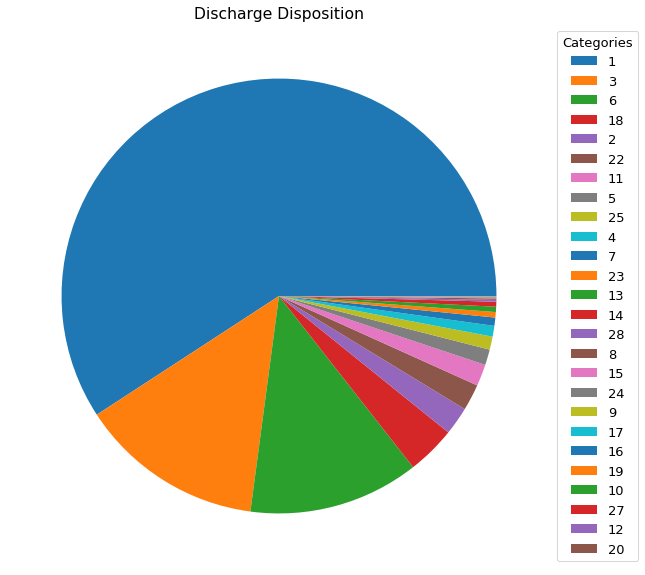

In [189]:
cats = df["discharge_disposition_id"]
#map(lambda x: x if pd.notnull(x) else "Other")
cats = cats.value_counts()

fig1, ax1 = plt.subplots(figsize=(10,10))

wedges, texts = ax1.pie(cats, 
        #autopct = lambda x: int(np.round(x/100.*sum(cats), 0)),
        textprops=dict(color="w"))

ax1.legend(wedges, cats.index,
          title="Categories",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))
plt.setp(autotexts, size=15, weight="bold")
plt.title("Discharge Disposition")

Text(0.5, 0, 'Age group')

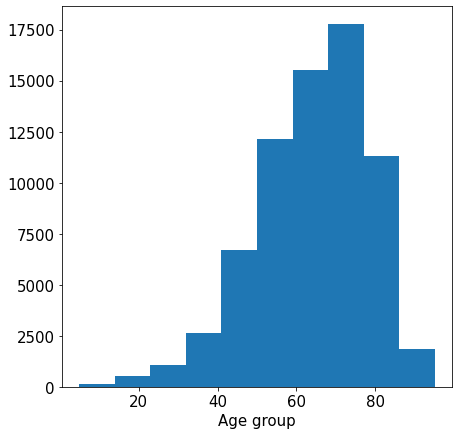

In [175]:
fig, ax = plt.subplots(figsize=(7,7))
plt.rcParams.update({'font.size': 15})
ax.hist(dfcleaned["age"])
plt.xlabel("Age group")


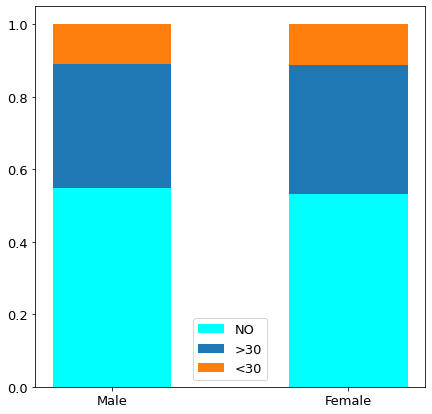

In [181]:
#stacked bar chart on distribution of readmission status across genders

#calculating the bar heights
fig, ax = plt.subplots(figsize=(7,7))
nos = [len(df.loc[(df["gender"]==label)&(df["readmitted"]=="NO"), :])
         for label in ["Male", "Female"]]

bigs = [len(df.loc[(df["gender"]==label)&(df["readmitted"]==">30"), :])
         for label in ["Male", "Female"]]

smalls = [len(df.loc[(df["gender"]==label)&(df["readmitted"]=="<30"), :])
         for label in ["Male", "Female"]]

total0 = nos[0]+bigs[0]+smalls[0]
total1 = nos[1]+bigs[1]+smalls[1]
nos[0] = nos[0]/total0
bigs[0] = bigs[0]/total0
smalls[0] = smalls[0]/total0
nos[1] = nos[1]/total1
bigs[1] = bigs[1]/total1
smalls[1] = smalls[1]/total1

#plotting
plt.rcParams.update({'font.size': 13})
x=np.arange(2)

barWidth = 0.5
ax.bar(["Male", "Female"], nos, color='cyan', label="NO", width = barWidth)
ax.bar(["Male", "Female"], bigs, bottom = nos, label=">30", width = barWidth)
ax.bar(["Male", "Female"], smalls, bottom = [i+j for i,j in zip(nos, bigs)], label="<30", width = barWidth)


plt.legend()

# More Summary Statistics on Drugs

In [41]:
for i in range(24, 47):
    print(df[df.columns[i]].value_counts())
    print()

No        81778
Steady    18346
Up         1067
Down        575
Name: metformin, dtype: int64

No        100227
Steady      1384
Up           110
Down          45
Name: repaglinide, dtype: int64

No        101063
Steady       668
Up            24
Down          11
Name: nateglinide, dtype: int64

No        101680
Steady        79
Up             6
Down           1
Name: chlorpropamide, dtype: int64

No        96575
Steady     4670
Up          327
Down        194
Name: glimepiride, dtype: int64

No        101765
Steady         1
Name: acetohexamide, dtype: int64

No        89080
Steady    11356
Up          770
Down        560
Name: glipizide, dtype: int64

No        91116
Steady     9274
Up          812
Down        564
Name: glyburide, dtype: int64

No        101743
Steady        23
Name: tolbutamide, dtype: int64

No        94438
Steady     6976
Up          234
Down        118
Name: pioglitazone, dtype: int64

No        95401
Steady     6100
Up          178
Down         87
Name: rosiglit

# Data cleaning

In [78]:
def mydrop(dfcleaned):
    #drop these columns
    dfcleaned = dfcleaned.drop(["weight", "payer_code","medical_specialty", "diag_2","diag_3","encounter_id"], axis=1)
    
    #two medicines with no dosage at all
    dfcleaned = dfcleaned.drop(["examide","citoglipton"], axis=1)
    
    #drop if gender unknown
    dfcleaned = dfcleaned[dfcleaned["gender"] != "Unknown/Invalid"]

    #drop if gender unknown
    dfcleaned = dfcleaned[dfcleaned["race"] != "?"]
    
    #drop if icd unknown
    dfcleaned = dfcleaned[dfcleaned["diag_1"] != "?"]
    
    #drop multiple patient records
    dfcleaned = dfcleaned.drop_duplicates(subset= ['patient_nbr'], keep = 'first')

    #drop patient_nbr
    dfcleaned = dfcleaned.drop(["patient_nbr"], axis=1)
    
    return dfcleaned

def icd_transform(dfcleaned):
    def icd_trans(code):
        code = code.replace(".","")
        part = icd[icd["ICD"].apply(lambda x: x.startswith(code))]
        res = part["CAT"].iloc[0]
        return res
    dfcleaned["diag"] = dfcleaned["diag_1"].apply(icd_trans)
    dfcleaned = dfcleaned.drop(["diag_1"],axis=1)
    return dfcleaned
    

def collapse(df):
    
    """
    Custom regrouping/collapsing of categorical features 
    Discharge, admission type and admission source
    """
    df['admission_type_id'] = df['admission_type_id'].replace(2,1)
    df['admission_type_id'] = df['admission_type_id'].replace(7,1)
    df['admission_type_id'] = df['admission_type_id'].replace(6,5)
    df['admission_type_id'] = df['admission_type_id'].replace(8,5)

    ####
    # discharge
    ####
    df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(6,8)
    
    df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(25, 18)
    
    df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(23, 3)
    df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(4, 3)
    df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(5, 3)
    df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(2, 3)
    df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(9, 3)
    df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(10, 3)
    df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(22, 3)
    df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(24, 3)
    df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(27, 3)
    df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(28, 3)
    df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(15, 3)
    
    df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(24, 3)
    df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(24, 3)

    df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(28, 15)
    df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(27, 15)
    
    ###
    # admission source
    ###
    df['admission_source_id'] = df['admission_source_id'].replace(23, 13)
    df['admission_source_id'] = df['admission_source_id'].replace(24, 13)
    df['admission_source_id'] = df['admission_source_id'].replace(11, 13)
    df['admission_source_id'] = df['admission_source_id'].replace(12, 13)
    
    df['admission_source_id'] = df['admission_source_id'].replace(10, 4)
    df['admission_source_id'] = df['admission_source_id'].replace(22, 4)
    df['admission_source_id'] = df['admission_source_id'].replace(25, 4)
    
    df['admission_source_id'] = df['admission_source_id'].replace(5, 6)
    
    df['admission_source_id'] = df['admission_source_id'].replace(2, 1)
    df['admission_source_id'] = df['admission_source_id'].replace(3, 1)
    
    df['admission_source_id'] = df['admission_source_id'].replace(9, 20)
    df['admission_source_id'] = df['admission_source_id'].replace(17, 20)    
                                        
    

In [79]:
def agemap(df):

    # convert age categories to mid-point values
    age_dict = {"[0-10)":5, "[10-20)":15, "[20-30)":25, "[30-40)":35, "[40-50)":45, 
                "[50-60)":55, "[60-70)":65, "[70-80)":75, "[80-90)":85, "[90-100)":95}
    df['age'] = df.age.map(age_dict)

In [80]:
## data cleaning


dfcleaned = df.copy()
dfcleaned = mydrop(dfcleaned)
dfcleaned = icd_transform(dfcleaned)
collapse(dfcleaned)
agemap(dfcleaned)





# Further preprocessing (med treatments)

## insulin processing (and metformin)

In [90]:
meds = dfcleaned_reduced.columns[16:37]
meds

Index(['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone'],
      dtype='object')

In [91]:
# taking out insulin and store in new df

dfcleaned_insulin = dfcleaned_reduced[list(dfcleaned_reduced.columns.difference(meds))]
dfcleaned_insulin.loc[:,"insulin"] = dfcleaned_reduced.loc[:,"insulin"]

dfcleaned_insulin.to_csv("dfcleaned_insulin.csv", index=False)

/Users/yuepengwang/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/yuepengwang/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [95]:
# taking out metformin and store in new df

dfcleaned_metformin = dfcleaned_reduced[list(dfcleaned_reduced.columns.difference(meds))]
dfcleaned_metformin.loc[:,"metformin"] = dfcleaned_reduced.loc[:,"metformin"]

dfcleaned_metformin.to_csv("dfcleaned_metformin.csv", index=False)

/Users/yuepengwang/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/yuepengwang/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


## constructing features indicating combinations of Insulin and Metformin

In [96]:
combo = dfcleaned_reduced.apply(lambda x: "(" + x["insulin"] + "," + x["metformin"] + ")", axis=1)
dfcleaned_insulin_metformin = dfcleaned_reduced.copy()
dfcleaned_insulin_metformin.loc[:,"insulin_metformin_combo"] = combo
dfcleaned_insulin_metformin = dfcleaned_insulin_metformin[list(dfcleaned_insulin_metformin.columns.difference(meds))]
dfcleaned_insulin_metformin.to_csv("dfcleaned_insulin_metformin.csv", index=False)

In [100]:
dfcleaned_insulin_metformin["insulin_metformin_combo"].value_counts()

(No,No)            21676
(Steady,No)        14605
(No,Steady)         5685
(Down,No)           5291
(Up,No)             4559
(Steady,Steady)     3640
(Up,Steady)         1024
(Down,Steady)        996
(No,Up)              259
(Steady,Up)          241
(No,Down)            141
(Steady,Down)        132
(Up,Up)               91
(Down,Up)             84
(Down,Down)           46
(Up,Down)             31
Name: insulin_metformin_combo, dtype: int64

In [ ]:
#pick subset of groups 
groups = ["(No,No)","(Steady,No)","(No,Steady)","(Down,No)","(Up,No)","(Steady,Steady)"]
dfcleaned_insulin_metformin_agg = dfcleaned_insulin_metformin.copy()
res = dfcleaned_insulin_metformin_agg.loc[:,"insulin_metformin_combo"].apply(lambda x:
                                                                      x if x in groups else "Other")
dfcleaned_insulin_metformin_agg.loc[:,"insulin_metformin_combo"] = res


In [106]:
dfcleaned_insulin_metformin_agg.to_csv("dfcleaned_insulin_metformin_agg.csv", index=False)